# CVE + MITRE Threat Intelligence - EDA Notebok

This notebook performs data cleaning and exploratory data analysis (EDA) on the combined NVD CVE and MITRE ATT&CK dataset. The goal is to prepare a clean dataset for use in an interactive Streamlit dashboard.

- CVE: Common Vulnerabilities and Exposures

- MITRE: Originally an acronym, but now it's simply "MITRE Corporation," a non-profit organization managing CVE and other cybersecurity initiatives.

Both are important in cybersecurity—CVE tracks security vulnerabilities, while MITRE helps develop frameworks like ATTACK for threat analysis.

In [19]:
!pip3 install --upgrade pip
!pip3 install -r requirements.txt 

Purpose of the Code
- Upgrading pip ensures that you avoid potential issues with outdated package management.
- Installing dependencies (requirements.txt) allows your project to have the necessary packages to function correctly.

Insights from the Code

- The installation will include useful libraries like: 
    - pandas for data manipulation
    - matplotlib & seaborn for visualization
    - streamlit for creating interactive web apps 
    - plotly for interactive graphs.

In [20]:
import json
import pandas as pd

# Load CVE data from NVD JSON
with open("nvdcve-1.1-2024.json", "r", encoding="utf-8") as file:
    data = json.load(file)

cve_items = data["CVE_Items"]
records = []

for item in cve_items:
    cve_id = item["cve"]["CVE_data_meta"]["ID"]
    published = item.get("publishedDate", "")
    description = item["cve"]["description"]["description_data"][0]["value"]

    impact = item.get("impact", {})
    score = None
    severity = None
    if "baseMetricV3" in impact:
        score = impact["baseMetricV3"]["cvssV3"]["baseScore"]
        severity = impact["baseMetricV3"]["cvssV3"]["baseSeverity"]
    elif "baseMetricV2" in impact:
        score = impact["baseMetricV2"]["cvssV2"]["baseScore"]
        severity = impact["baseMetricV2"]["severity"]

    cwe_data = item["cve"]["problemtype"]["problemtype_data"]
    cwe_id = "N/A"
    if cwe_data and cwe_data[0]["description"]:
        cwe_id = cwe_data[0]["description"][0]["value"]

    records.append({
        "cve_id": cve_id,
        "published_date": published,
        "cvss_score": score,
        "severity": severity,
        "cwe_id": cwe_id,
        "description": description
    })

df_cve = pd.DataFrame(records)


Purpose of the Code
- Extracts and organizes CVE data from the National Vulnerability Database.
- Saves security vulnerability details into a structured format for analysis.
- Helps evaluate risks based on severity ratings and classification codes.

Insights from the Code
- Converts JSON data into a structured table for easy examination.
- Assesses vulnerabilities using CVSS scores and severity levels.
- Enables cybersecurity teams to categorize and prioritize threats.

In [21]:
# Load your manual attack-pattern.json
with open("attack-pattern.json", "r", encoding="utf-8") as f:
    attack_data = json.load(f)

# Extract CWE & MITRE mappings
records = []
for obj in attack_data["objects"]:
    if obj.get("type") == "attack-pattern" and "external_references" in obj:
        technique_id = next((ref["external_id"] for ref in obj["external_references"] if ref["source_name"] == "mitre-attack"), None)
        cwe_ids = [ref["external_id"] for ref in obj["external_references"] if ref["source_name"] == "cwe"]
        tactic = ", ".join(sorted(set(phase["phase_name"] for phase in obj.get("kill_chain_phases", []))))
        for cwe in cwe_ids:
            records.append({
                "cwe_id": cwe,
                "mitre_technique_id": technique_id,
                "mitre_tactic": tactic
            })
            
# Create DataFrame of mappings
df_mitre = pd.DataFrame(records)

Purpose of the Code
- Loads CVE data from a CSV file and attack-pattern mappings from a JSON file.
- Extracts CWE-to-MITRE ATTACK mappings for security analysis.
- Merges enriched data to provide a more comprehensive vulnerability dataset.

Insights from the Code
- Connects CVE vulnerabilities to MITRE techniques and tactics.
- Enables threat intelligence analysis with structured CWE mappings.
- Saves an enriched dataset for further cybersecurity assessments.

In [22]:
df_cve.head()

,cve_id,published_date,cvss_score,severity,cwe_id,description
0,CVE-2024-0001,2024-09-23T18:15Z,9.8,CRITICAL,CWE-1188,A condition exists in FlashArray Purity whereb...
1,CVE-2024-0002,2024-09-23T18:15Z,9.8,CRITICAL,NVD-CWE-noinfo,A condition exists in FlashArray Purity whereb...
2,CVE-2024-0003,2024-09-23T18:15Z,7.2,HIGH,NVD-CWE-noinfo,A condition exists in FlashArray Purity whereb...
3,CVE-2024-0004,2024-09-23T18:15Z,7.2,HIGH,CWE-94,A condition exists in FlashArray Purity whereb...
4,CVE-2024-0005,2024-09-23T18:15Z,8.8,HIGH,CWE-77,A condition exists in FlashArray and FlashBlad...


In [23]:
df_mitre.head()

,cwe_id,mitre_technique_id,mitre_tactic
0,CWE-79,T1059,execution
1,CWE-119,T1068,privilege-escalation
2,CWE-20,T1203,initial-access
3,CWE-200,T1082,discovery
4,CWE-352,T1078,credential-access


## Data Cleaning

In [24]:
import pandas as pd
import numpy as np


print("CVE Data Shape:", df_cve.shape)
print("Mitre Data Shape:", df_mitre.shape)


CVE Data Shape: (37818, 6)
Mitre Data Shape: (10, 3)


In [25]:
print("CVE Data Info:")
print(df_cve.info())

print("\n Mitre Data Info:")
print(df_mitre.info())

CVE Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37818 entries, 0 to 37817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cve_id          37818 non-null  object 
 1   published_date  37818 non-null  object 
 2   cvss_score      20512 non-null  float64
 3   severity        20512 non-null  object 
 4   cwe_id          37818 non-null  object 
 5   description     37818 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.7+ MB
None

 Mitre Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cwe_id              10 non-null     object
 1   mitre_technique_id  10 non-null     object
 2   mitre_tactic        10 non-null     object
dtypes: object(3)
memory usage: 372.0+ bytes
None


In [26]:
import pandas as pd

# Check missing values 
missing_df_cve = pd.DataFrame(df_cve.isnull().sum(), columns=["Missing Values in CVE Data"])
missing_df_mitre = pd.DataFrame(df_mitre.isnull().sum(), columns=["Missing Values in Enriched Data"])

# Display tables
print("CVE Data Missing Values:")
print(missing_df_cve)

print("\nEnriched Data Missing Values:")
print(missing_df_mitre)


CVE Data Missing Values:
                Missing Values in CVE Data
cve_id                                   0
published_date                           0
cvss_score                           17306
severity                             17306
cwe_id                                   0
description                              0

Enriched Data Missing Values:
                    Missing Values in Enriched Data
cwe_id                                            0
mitre_technique_id                                0
mitre_tactic                                      0


In [27]:
import pandas as pd
import numpy as np

# Dynamic data cleansing
def cleanse_data(df):
   # Convert numeric columns
    for col in df.select_dtypes(include=["int64", "float64"]).columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Handle missing values dynamically
    for col in df.columns:
        if df[col].dtype == "object":
            df[col].fillna("Unknown", inplace=True)  # Fill missing text
        elif df[col].dtype in ["int64", "float64"]:
            df[col].fillna(0, inplace=True)  # Fill missing numbers with 0

    # Normalize text data
    for col in df.select_dtypes(include=["string"]).columns:
        df[col] = df[col].str.strip().str.lower()

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df

# Apply data cleansing functions
df_cve = cleanse_data(df_cve)
df_mitre= cleanse_data(df_mitre)

df_cve["published_date"] = pd.to_datetime(df_cve["published_date"], errors="coerce")

print("Data cleansing completed and saved!")

Data cleansing completed and saved!


/var/folders/vk/hr1shnhn29bd_67yn_dv6_3c0000gn/T/ipykernel_8967/1279703038.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)  # Fill missing text
/var/folders/vk/hr1shnhn29bd_67yn_dv6_3c0000gn/T/ipykernel_8967/1279703038.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [28]:
# Merge with CVE data
df_merged = pd.merge(df_cve, df_mitre, on="cwe_id", how="left")
df_merged['year'] = df_merged['published_date'].dt.year

# Save final result after cleaning and merging
df_merged.to_csv("CVE_MITRE_Mappings.csv", index=False)
print("Final file saved as CVE_MITRE_Mappings.csv")

Final file saved as CVE_MITRE_Mappings.csv


In [29]:
# Create a verification table for CVE dataset
verification_df = pd.DataFrame({
    "Data Type": df_cve.dtypes,
    "Missing Values": df_cve.isnull().sum()
}).reset_index()
verification_df.columns = ["Column Name", "Data Type", "Missing Values"]

print("Data types and missing values in CVE Data after cleaning:\n")
print(verification_df)

# Create a verification table for Enriched dataset
verification_df_enriched = pd.DataFrame({
    "Data Type": df_mitre.dtypes,
    "Missing Values": df_mitre.isnull().sum()
}).reset_index()
verification_df_enriched.columns = ["Column Name", "Data Type", "Missing Values"]

print("\nData types and missing values in Enriched Data after cleaning:\n")
print(verification_df_enriched)


Data types and missing values in CVE Data after cleaning:

      Column Name            Data Type  Missing Values
0          cve_id               object               0
1  published_date  datetime64[ns, UTC]               0
2      cvss_score              float64               0
3        severity               object               0
4          cwe_id               object               0
5     description               object               0

Data types and missing values in Enriched Data after cleaning:

          Column Name Data Type  Missing Values
0              cwe_id    object               0
1  mitre_technique_id    object               0
2        mitre_tactic    object               0


Purpose of the Code
- Checks for null values and provides an overview of the dataset.
- Converts date columns into structured time formats for analysis.
- Creates visualizations to explore data distributions and relationships.

Insights from the Code
- Identifies missing data using a heatmap for better data quality assessment.
- Shows CVE severity distribution and common CWE classifications.


## Exploratory Data Analysis

In [30]:
print("Merged Data Summary:")
print(df_merged.info())
print(df_merged.describe(include='all'))

Merged Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37818 entries, 0 to 37817
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   cve_id              37818 non-null  object             
 1   published_date      37818 non-null  datetime64[ns, UTC]
 2   cvss_score          37818 non-null  float64            
 3   severity            37818 non-null  object             
 4   cwe_id              37818 non-null  object             
 5   description         37818 non-null  object             
 6   mitre_technique_id  5605 non-null   object             
 7   mitre_tactic        5605 non-null   object             
 8   year                37818 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), object(6)
memory usage: 2.5+ MB
None
               cve_id                       published_date    cvss_score  \
count           37818            

In [31]:
categorical_summary = df_merged.select_dtypes(include=["object"]).describe().transpose()
print("Categorical Summary:\n", categorical_summary)


Categorical Summary:
                     count unique  \
cve_id              37818  37818   
severity            37818      5   
cwe_id              37818    283   
description         37818  35591   
mitre_technique_id   5605      9   
mitre_tactic         5605      8   

                                                                  top   freq  
cve_id                                                  CVE-2024-0001      1  
severity                                                      Unknown  17306  
cwe_id                                                            N/A  17367  
description         Rejected reason: This CVE ID has been rejected...    241  
mitre_technique_id                                              T1059   4335  
mitre_tactic                                                execution   4335  


In [32]:
numerical_summary = df_merged.select_dtypes(include=["int64", "float64"]).describe().transpose()
print("Numerical Summary:\n", numerical_summary)

Numerical Summary:
               count      mean       std  min  25%  50%  75%   max
cvss_score  37818.0  3.738141  3.657166  0.0  0.0  4.8  7.1  10.0


In [33]:
# CVE Data Correlation Matrix
numeric_columns_df = df_merged.select_dtypes(include=["number"])
correlation_matrix_df = numeric_columns_df.corr()

print("Correlation matrix for CVE Data:\n", correlation_matrix_df)

Correlation matrix for CVE Data:
             cvss_score     year
cvss_score     1.00000 -0.12771
year          -0.12771  1.00000


# Visulisations

### 1. CVEs Reported Over Time

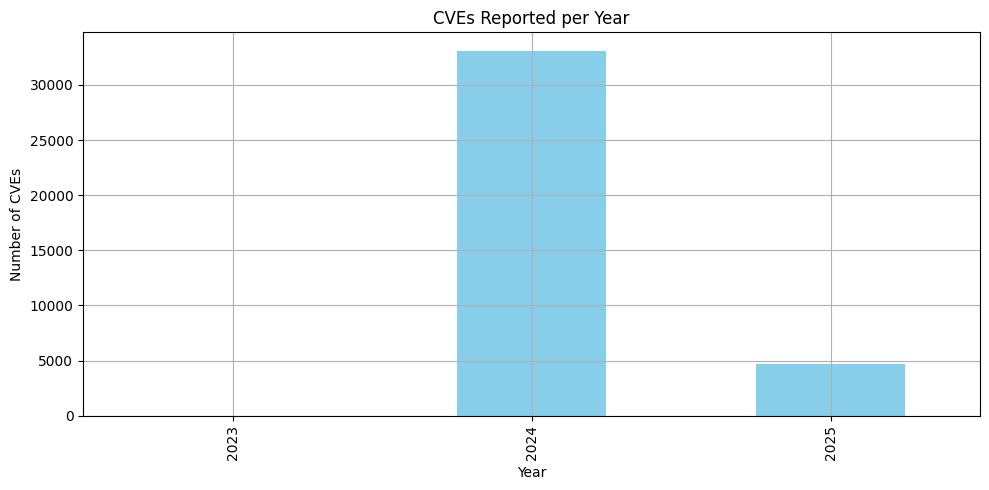

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,5))
df_merged['year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("CVEs Reported per Year")
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.grid(True)
plt.tight_layout()
plt.show()

Purpose of the Code
- Generates a bar chart displaying the number of CVEs reported per year.
- Uses Matplotlib for visualization and enhances readability with formatting.
- Helps identify trends in vulnerability disclosures over time.

Insights from the Code
- Shows the distribution of CVEs across different years for trend analysis.
- Allows cybersecurity teams to examine patterns in vulnerability reporting.
- Provides a clear visual representation of the dataset's temporal aspects.

### 2 CVSS Score Distribution

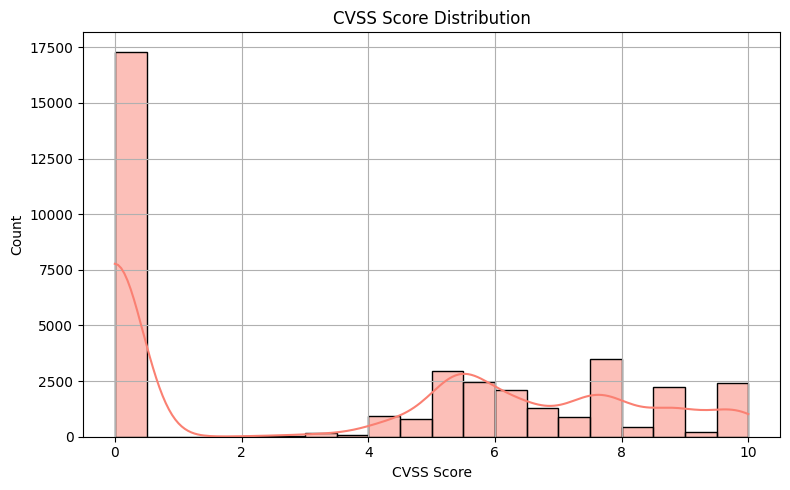

In [35]:
plt.figure(figsize=(8,5))
sns.histplot(df_merged['cvss_score'], bins=20, kde=True, color='salmon')
plt.title("CVSS Score Distribution")
plt.xlabel("CVSS Score")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Purpose of the Code
- Creates a histogram to visualize the distribution of CVSS scores.
- Uses Seaborn's histplot with Kernel Density Estimation (KDE) for smooth trend analysis.
- Enhances readability with labels, grid, and tight layout adjustments.

Insights from the Code
- Highlights the frequency of different CVSS scores in the dataset.
- Helps assess the severity spread of vulnerabilities.
- Provides a clear view of how CVE scores are distributed.

### 3 Severity Breakdown

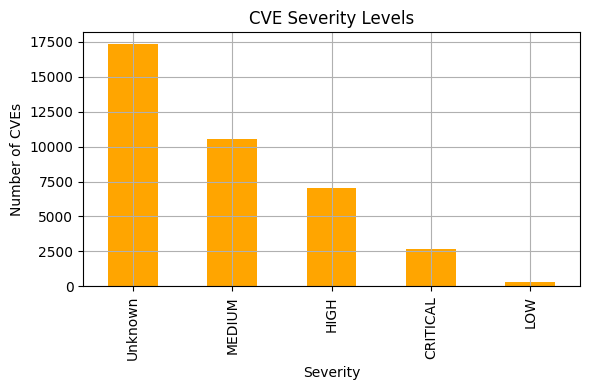

In [36]:
plt.figure(figsize=(6,4))
df_merged['severity'].value_counts().plot(kind='bar', color='orange')
plt.title("CVE Severity Levels")
plt.ylabel("Number of CVEs")
plt.xlabel("Severity")
plt.grid(True)
plt.tight_layout()
plt.show()

Purpose of the Code
- Creates a bar chart to display the distribution of CVE severity levels.
- Uses pandas plotting functionality to visualize vulnerability severity.
- Enhances readability with labels, gridlines, and tight layout adjustments.

Insights from the Code
- Shows how vulnerabilities are categorized by severity.
- Helps assess risk levels based on reported CVEs.
- Provides a quick overview of security threats in the dataset.

### 4 Top 10 CWE Categories

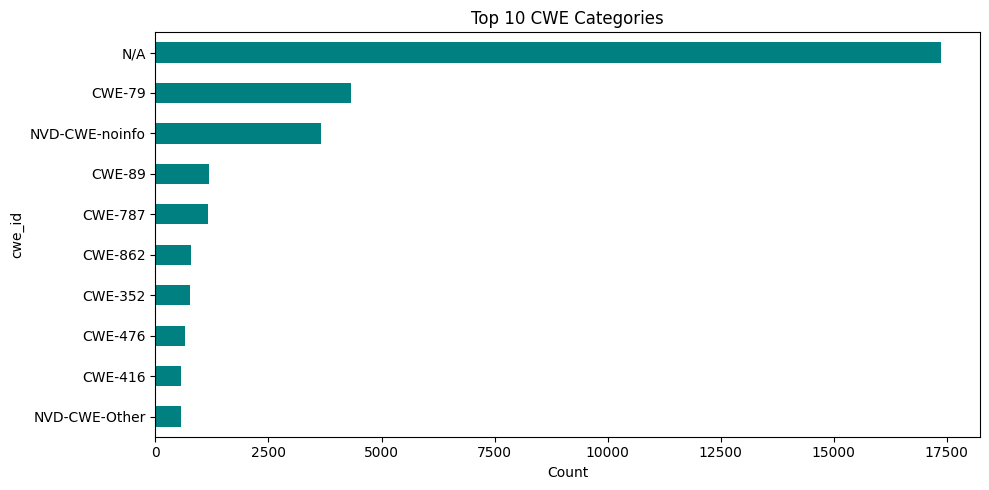

In [37]:
top_cwes = df_merged['cwe_id'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
top_cwes.plot(kind='barh', color='teal')
plt.title("Top 10 CWE Categories")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Purpose of the Code
- Identifies the top 10 most common CWE categories in the dataset.
- Creates a horizontal bar chart for better readability and comparison.
- Enhances visualization with proper labels, layout adjustments, and axis inversion.

Insights from the Code
- Highlights the most frequently occurring CWE vulnerabilities.
- Helps prioritize security threats based on reported CWE patterns.
- Provides a structured view of common weakness categories for analysis.

### 5. How Many CVEs Are Mapped to MITRE ATT&CK?

In [38]:
mapped_ratio = df_merged['mitre_technique_id'].notnull().mean() * 100
print(f"{mapped_ratio:.2f}% of CVEs have a mapped MITRE technique.")

14.82% of CVEs have a mapped MITRE technique.


Purpose of the Code
- Calculates the percentage of CVEs that have a mapped MITRE ATT&CK technique.
- Uses .notnull().mean() to determine the proportion of mapped entries.
- Prints the final percentage in a user-friendly formatted output.

Insights from the Code
- Provides a quick assessment of how many CVEs are linked to known attack techniques.
- Helps gauge the coverage of MITRE ATT&CK mappings in the dataset.
- Supports cybersecurity analysis by quantifying intelligence integration.